# Marelle Board import
* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.id_to_action`
* Action:Id dict => `MarelleBoard.action_to_id`
* Get the board state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end(player)`

In [30]:
import importlib

import marl_env
import marl_agents
import marl_models
import marl_evaluations
importlib.reload(marl_env)
importlib.reload(marl_agents)
importlib.reload(marl_models)
importlib.reload(marl_evaluations)

from marl_env import MarelleBoard, MarelleGymEnv, MarelleGame
from marl_models import FCModel, ConvModel
from marl_agents import RandomAgent, BetterRandomAgent, SingleModelReinforce, ReinforceAgent, MarelleAgent
from marl_train import train_agent
from marl_evaluations import evaluate

import progressbar as pb
import numpy as np 
import os
import cProfile

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb

import torch
import torch.nn as nn

# Training
## Place phase

Episode 1/20: rewards -1.02 +/- 1.19 - Loss : -57.781864166259766
Episode 2/20: rewards -1.38 +/- 1.15 - Loss : -78.36835479736328
Episode 3/20: rewards -1.56 +/- 0.96 - Loss : -89.31250762939453
Episode 4/20: rewards -1.26 +/- 1.11 - Loss : -72.10443115234375
Episode 5/20: rewards -1.04 +/- 1.11 - Loss : -59.786075592041016
Episode 6/20: rewards -1.06 +/- 1.01 - Loss : -61.02227020263672
Episode 7/20: rewards -1.14 +/- 1.33 - Loss : -65.64575958251953
Episode 8/20: rewards -1.06 +/- 1.32 - Loss : -61.46491241455078
Episode 9/20: rewards -1.38 +/- 1.07 - Loss : -80.57272338867188
Episode 10/20: rewards -1.54 +/- 1.02 - Loss : -90.4598617553711
Episode 11/20: rewards -1.56 +/- 1.13 - Loss : -91.76946258544922
Episode 12/20: rewards -1.44 +/- 1.17 - Loss : -85.0822525024414
Episode 13/20: rewards -1.04 +/- 1.15 - Loss : -61.89840316772461
Episode 14/20: rewards -1.1 +/- 1.08 - Loss : -65.75033569335938
Episode 15/20: rewards -1.24 +/- 1.27 - Loss : -74.97399139404297
Episode 16/20: rewar

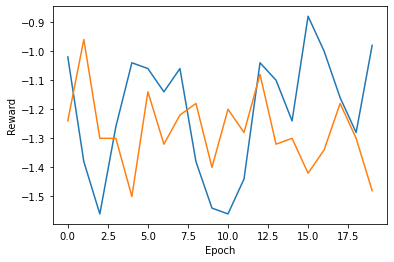

In [9]:
env = MarelleGymEnv(end_after_place_phase=True)

# Models
einstein_fc_model = FCModel(env.N_STATE, env.N_TOTAL_PLACE_ACTIONS)
einstein_conv_model = ConvModel(env.N_TOTAL_PLACE_ACTIONS)

# Agents
einstein_fc = SingleModelReinforce(env=env, player_id=1, model=einstein_fc_model, lr=0.005, win_reward=0, defeat_reward=0, capture_reward=2, captured_reward=-1, epsilon=0, gamma=1)

einstein_conv = SingleModelReinforce(env=env, player_id=1, model=einstein_conv_model, lr=0.00005, win_reward=0, defeat_reward=0, capture_reward=2, captured_reward=-1, epsilon=0, gamma=1)

# Opponents
opponent_agent=BetterRandomAgent(env, -1)
evaluate_agent=RandomAgent(env,-1)

# Training Fully Connected agent
train_agent(
    env=env,
    n_epochs=20,
    n_trajectories=50,
    trained_agent=einstein_fc,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=999999 # no evaluation for just the place phase
)

# Training Conv agent
train_agent(
    env=env,
    n_epochs=20,
    n_trajectories=50,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=999999 # no evaluation for just the place phase
)

## Full game training

Training Fully Connected agent
Episode 1/10: rewards -1.6 +/- 0.13 - Loss : -284.55694580078125
Episode 2/10: rewards -1.43 +/- 0.68 - Loss : -223.02084350585938
{'n_actions': 47.72, 'n_captures_place': 0.11, 'n_captured_place': 1.79, 'n_captures_move': 0.76, 'n_captured_move': 5.12, 'draws_%': 0.0, 'victories_capture_%': 0.02, 'victories_block_%': 0.0, 'defeats_capture_%': 0.98, 'defeats_block_%': 0.0}
Episode 3/10: rewards -1.44 +/- 0.67 - Loss : -219.9662628173828
Episode 4/10: rewards -1.39 +/- 0.66 - Loss : -212.6968994140625
{'n_actions': 45.55, 'n_captures_place': 0.06, 'n_captured_place': 1.84, 'n_captures_move': 0.73, 'n_captured_move': 5.02, 'draws_%': 0.0, 'victories_capture_%': 0.02, 'victories_block_%': 0.01, 'defeats_capture_%': 0.97, 'defeats_block_%': 0.0}
Episode 5/10: rewards -1.53 +/- 0.16 - Loss : -288.347900390625
Episode 6/10: rewards -1.44 +/- 0.7 - Loss : -200.03445434570312
{'n_actions': 48.82, 'n_captures_place': 0.03, 'n_captured_place': 1.91, 'n_captures_mov

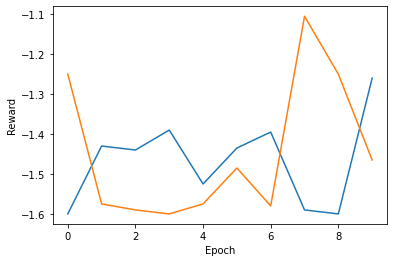

In [20]:
env = MarelleGymEnv(end_after_place_phase=False)

# Models
einstein_fc_model = FCModel(env.N_STATE, env.N_TOTAL_ACTIONS)
einstein_conv_model = ConvModel(env.N_TOTAL_ACTIONS)

# Agents
einstein_fc = SingleModelReinforce(env=env, player_id=1, model=einstein_fc_model, lr=0.005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

einstein_conv = SingleModelReinforce(env=env, player_id=1, model=einstein_conv_model, lr=0.00005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

# Opponents
opponent_agent=BetterRandomAgent(env, -1)
evaluate_agent=BetterRandomAgent(env,-1)

print("Training Fully Connected agent")
train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_fc,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=2
)

# Training Conv agent
print("Training Conv agent")
train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=2
)

Training Fully Connected agent
Episode 1/10: rewards -1.56 +/- 0.13 - Loss : -247.92822265625
Episode 2/10: rewards -1.27 +/- 0.9 - Loss : -161.34286499023438
Episode 3/10: rewards -1.45 +/- 0.73 - Loss : -225.48300170898438
Episode 4/10: rewards -1.38 +/- 0.64 - Loss : -238.56396484375
Episode 5/10: rewards -0.97 +/- 1.19 - Loss : -157.02464294433594
Episode 6/10: rewards -1.27 +/- 0.89 - Loss : -198.79312133789062
Episode 7/10: rewards -1.4 +/- 0.63 - Loss : -215.7202606201172
Episode 8/10: rewards -1.58 +/- 0.12 - Loss : -257.0482177734375
Episode 9/10: rewards -1.58 +/- 0.18 - Loss : -285.20489501953125
Episode 10/10: rewards -1.37 +/- 0.61 - Loss : -232.7567596435547
Training Conv agent
Episode 1/10: rewards -1.59 +/- 0.12 - Loss : -237.5885467529297
Episode 2/10: rewards -1.42 +/- 0.71 - Loss : -236.830078125
Episode 3/10: rewards -1.57 +/- 0.13 - Loss : -251.1207733154297
Episode 4/10: rewards -0.86 +/- 1.34 - Loss : -98.38566589355469
Episode 5/10: rewards -1.56 +/- 0.12 - Loss

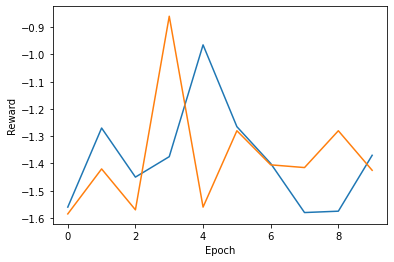

In [2]:
env = MarelleGymEnv(end_after_place_phase=False)

# Models
einstein_fc_model = FCModel(env.N_STATE, env.N_TOTAL_ACTIONS)
einstein_conv_model = ConvModel(env.N_TOTAL_ACTIONS)

# Agents
einstein_fc = SingleModelReinforce(env=env, player_id=1, model=einstein_fc_model, lr=0.005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

einstein_conv = SingleModelReinforce(env=env, player_id=1, model=einstein_conv_model, lr=0.00005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

# Opponents
opponent_agent=BetterRandomAgent(env, -1)
evaluate_agent=BetterRandomAgent(env,-1)

print("Training Fully Connected agent")
train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_fc,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=20
)

# Training Conv agent
print("Training Conv agent")
train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=20
)

## Restoring Models

In [5]:
def load_model(model_name, run_id, model):
    wandb.restore(model_name, run_path=f'clement-guillo/marl/{run_id}',root= "models/temp/")
    model.load_state_dict(torch.load(f'models/temp/{model_name}'))
    os.remove(f'models/temp/{model_name}')
    return(model)

# einstein_model=load_model('model_1_200.pt','d5zabrxq',FCModel(len(env.board.get_state()),len(env.board.id_to_action)))
# einstein=Reinforce(env, 1, einstein_model, lr=0.0001, incentivize_captures=False, punish_opponent_captures=False)


# Playing games

In [34]:
env = MarelleGymEnv()
piccolo = BetterRandomAgent(env, -1)

# game = MarelleGame(env=env, player1=piccolo, player2=einstein)
game = MarelleGame(env=env, player1="human", player2=piccolo)

In [35]:
action_history = game.play()

BetterRandomAgent 2's turn to play :

        Phase : move
        Placed tokens : P1 : 9 / P2 : 9 
        Tokens on board : P1 : 9 / P2 : 8 
        0--------------2--------------0
        |              |              |
        |    1---------1---------2    |
        |    |         |         |    |
        |    |    1----1----1    |    |
        |    |    |         |    |    |
        0----2----2         1----1----2                 
        |    |    |         |    |    |
        |    |    1----2----2    |    |
        |    |         |         |    |
        |    1---------0---------2    |
        |              |              |
        0--------------0--------------0
        


Exception: Illegal token move action

## Evaluating an agent by playing n_games

In [39]:
# TO EVALUATE AGENTS, ENSURE THEY HAVE THE SAME ENV !
env = MarelleGymEnv()
piccolo = BetterRandomAgent(env, 1)
gabrielle = RandomAgent(env, -1)

evaluation = evaluate(env, piccolo, gabrielle, 100, 1)
print(evaluation)

{'n_actions': 47.11, 'n_captures_place': 2.07, 'n_captured_place': 0.34, 'n_captures_move': 4.68, 'n_captured_move': 1.27, 'draws_%': 0.01, 'victories_capture_%': 0.91, 'victories_block_%': 0.05, 'defeats_capture_%': 0.03, 'defeats_block_%': 0.0}


# Time test

Episode 1/10: rewards -1.12 +/- 1.15 - Loss : -169.14926147460938
Episode 2/10: rewards -1.26 +/- 0.93 - Loss : -120.74156188964844
{'n_actions': 46.77, 'n_captures_place': 0.24, 'n_captured_place': 1.95, 'n_captures_move': 0.95, 'n_captured_move': 4.96, 'draws_%': 0.0, 'victories_capture_%': 0.03, 'victories_block_%': 0.0, 'defeats_capture_%': 0.97, 'defeats_block_%': 0.0}
Episode 3/10: rewards -1.32 +/- 0.9 - Loss : -164.70095825195312
Episode 4/10: rewards -1.59 +/- 0.18 - Loss : -256.78485107421875
{'n_actions': 48.47, 'n_captures_place': 0.28, 'n_captured_place': 2.0, 'n_captures_move': 0.99, 'n_captured_move': 4.77, 'draws_%': 0.02, 'victories_capture_%': 0.03, 'victories_block_%': 0.0, 'defeats_capture_%': 0.95, 'defeats_block_%': 0.0}
Episode 5/10: rewards -1.45 +/- 0.69 - Loss : -214.6808319091797
Episode 6/10: rewards -1.24 +/- 0.93 - Loss : -201.06552124023438
{'n_actions': 46.59, 'n_captures_place': 0.23, 'n_captured_place': 1.96, 'n_captures_move': 1.03, 'n_captured_move':

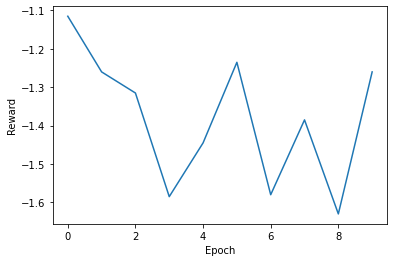

In [26]:
env = MarelleGymEnv(end_after_place_phase=False)

# Models
einstein_fc_model = FCModel(env.N_STATE, env.N_TOTAL_ACTIONS)
einstein_conv_model = ConvModel(env.N_TOTAL_ACTIONS)

# Agents
einstein_fc = SingleModelReinforce(env=env, player_id=1, model=einstein_fc_model, lr=0.005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

einstein_conv = SingleModelReinforce(env=env, player_id=1, model=einstein_conv_model, lr=0.00005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

# Opponents
opponent_agent=BetterRandomAgent(env, -1)
evaluate_agent=BetterRandomAgent(env,-1)

cProfile.run("""train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=2
)""", sort='tottime')

In [35]:
evaluation_agent = einstein_conv
env.reset()
gabrielle = BetterRandomAgent(env, -1)
piccolo = BetterRandomAgent(env, 1)

cProfile.run("evaluate(env, einstein_conv, gabrielle, 100, 1)", sort="tottime")

         12232816 function calls (12224140 primitive calls) in 7.245 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17261    1.734    0.000    4.569    0.000 marl_env.py:295(move_token_legal_actions)
  3075028    1.500    0.000    1.996    0.000 graph.py:656(nodes)
  3386710    0.559    0.000    0.559    0.000 reportviews.py:186(__getitem__)
  3075028    0.497    0.000    0.497    0.000 reportviews.py:176(__init__)
     6507    0.389    0.000    0.389    0.000 {built-in method conv2d}
   572913    0.384    0.000    0.387    0.000 reportviews.py:1116(__iter__)
   176551    0.363    0.000    0.455    0.000 marl_env.py:325(check_if_capture)
     3152    0.216    0.000    0.600    0.000 marl_env.py:252(place_token_legal_actions)
     2169    0.166    0.000    0.283    0.000 marl_models.py:41(transform_input_to_mat)
     8858    0.165    0.000    0.369    0.000 marl_env.py:227(get_state)
     4338    0.093    0.000    0.093